# Fluid-Structure Interaction using `Dyn3d` and `Whirl`

## <span style="color:blue"> Include Packages

In [142]:
using Pkg
Pkg.activate("..")

using Revise
using Dyn3d
using FSI

In [143]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [175]:
ndim = 2
# numerical params
tf = 1.0
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0.0, -1.0]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
function circle(z₀::Vector{Float64}, r::Float64, n::Int)
    # z₀ for circle center location, r for radius and n for # of points on circle
    verts = zeros(n,2)
    for i = 1:n
        verts[i,:] = [r*cos(2π/(n)*(i-1)) + z₀[1], r*sin(2π/(n)*(i-1)) + z₀[2]]
    end
    return verts
end

nbody = 1
nverts = 157
verts = circle([0.,0.], 0.5, nverts)
config_body = ConfigBody(nbody, nverts, verts, 2.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dofₚ = Dof(6, "passive", 0., 0., Motions())
config_joints[1] = ConfigJoint(njoint, "custom_prismatic_in_z",
    [0.0,0.0,0.0,1.0,0.0,2.0], zeros(Float64,6), 0, [dofₚ], [0.0])

 joint type = custom_prismatic_in_z
 joint position in parent body coord = [0.0, 0.0, 0.0, 1.0, 0.0, 2.0]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 6, under passive motion
 initial unconstrained dof position = [0.0]


#### Build joint-body chain

In [176]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is un-mounted from space

#### Initialize rigid body system state

In [177]:
# initialize system to complete body-joint information
bd, soln = InitSystem!(bd)

# initialize solution structure
solns = (Soln)[]
push!(solns, soln);

#### Get body verts for plotting

In [178]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, solns[1].qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

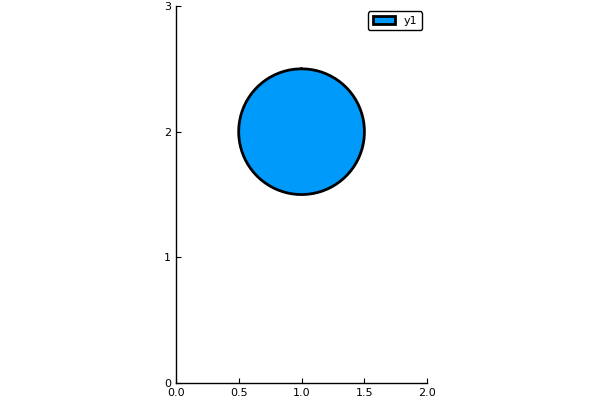

In [179]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,[1:nverts;1],1], vs₀[i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
end
plot!(xlims=(0,2), ylims=(0,3),ratio=1)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [180]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid and time step size

In [181]:
nx = 102; ny = 152;
Ly = 3.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:2.0100000000000002, -0.01:0.02:3.0100000000000002)

#### Set up initial conditions

In [182]:
t = 0.0
tf = 200*Δt
T = Δt:Δt:tf

w₀ .= 0.0
fx = Float64[]
fy = Float64[]
thist = []
uhist = []
bdhist = []
tsample = 0.02;

## <span style="color:blue"> Create fluid-body interface </span>

#### Genrate body grid points and get linear velocity on them

In [183]:
# bgs short for body grid system
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx));
bgs = AcquireBodyGridKinematics(bd,bgs)

coord = hcat(bgs[1].q_i...)'[:,[1,3]]
motion = hcat(bgs[1].v_i...)'[:,[1,3]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,3]]]
    motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,3]]]
end

#### Variable containers for all stages in IFHERK and HERKBody

In [184]:
# Herk stages for both body and fluid solver
NS = bd.sys.num_params.st
if NS != 3 error("Dyn3d RK scheme not the same with Whirl") end

# Body kinematics container for ifherk input and herkbody output
bkins = Vector{Array{Float64,2}}(undef,NS)

# Body force container for ifherk output(not integrated)
fs = Vector{Array{Float64,2}}(undef,NS)

# Body force container for herkbody input(integrated)
f_exis = [zeros(bd.sys.nbody,6) for i=1:NS]

# All body info container
bds = [bd for i=1:NS];

#### Get body points initial coordinates for fluids

In [185]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord = hcat(bgs[1].q_i...)'[:,[1,3]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,3]]]
end
coord_init = coord;

## <span style="color:blue"> Set up integrators for Time Marching </span>

#### Set up the Navier-Stokes  problem type

In [186]:
X̃ = VectorData(coord_init)
fsys = FSI.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 102 x 152

#### Constants for coupling

In [187]:
tol = 5e-4  # coupling tolerance
ω = (config_bodys[1].ρ)/(1.0+config_bodys[1].ρ)  # relaxation parameter

0.6666666666666666

#### Create Body solver object of type HerkBody

In [188]:
herkbody = Dyn3d.HERKBody(bd.sys.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
            ((bs,js,sys,f_exi) -> HERKFuncf(bs,js,sys,f_exi,"cylinder",config_body.ρ),HERKFuncgti),
            (UpdatePosition!,UpdateVelocity!))

Order-3 HERK time-marching function like object for Dyn3d


#### Create Fluid solver object of type IFHERK

In [189]:
u = w₀
f = VectorData(X̃)
fs = [[f.u f.v] for i=1:NS]

# construct fluid solver with uniform constant free stream
ifherk_sc2d = FSI.IFHERK_sc2d(u,f,fsys.Δt,
                (t,u) -> FSI.Systems.plan_intfact(t,u,fsys),
                (u,t,coord) -> FSI.plan_constraints(u,t,fsys,coord),
                ((u,t) -> FSI.r₁(u,t,fsys),
                 (u,t,motion) -> FSI.r₂(u,t,fsys,motion)),
                coord_init,
                tol=1e-3,rk=FSI.TimeMarching.RK31,
                isstored=true,isstaticconstraints=false)

Order-3 IF-HERK for fs interaction integrator with
   State of type Nodes{Dual,102,152}
   Force of type VectorData{157}
   Time step size 0.01


## <span style="color:blue"> Time Marching! </span>

#### Make timestep in Dyn3d the same with Whirl

In [190]:
soln.dt = Δt
solns[1].dt = soln.dt

# total number of body points in the fluid solver
np_total = round(Int,length(f)/2)

157

#### Proceed with normal coupling AFTER the first timestep

In [191]:
@time for ti in T
@time begin
    iter = 1
    fᵢ = fs.*Δx^2

    # record body info
    soln_buffer = deepcopy(soln)
    global bd
    bd_buffer = deepcopy(bd)
    bgs_buffer = deepcopy(bgs)

    # record fluid info
    u_buffer = deepcopy(u)
    t_buffer = t

    # interation until coupled
    while true

        #--------------------------------------------------------
        # get body state of the last timestep
        soln = deepcopy(soln_buffer)
        bd = deepcopy(bd_buffer)
        bgs = deepcopy(bgs_buffer)

        #--------------------------------------------------------
        # integrate body forces from body points
        for k = 1:NS
            b_cnt = 1
            ref = 0
            for i = 1:np_total
                # move to the next bgs if i exceed bgs[b_cnt].np
                if i > ref + bgs[b_cnt].np
                    ref += bgs[b_cnt].np
                    b_cnt += 1        
                end
                bgs[b_cnt].f_ex3d[i-ref][[1,3]] = fᵢ[k][i,:]
            end

            # integrate total forces from all body points on a body
            bgs = IntegrateBodyGridDynamics(bd,bgs)
            for i = 1:bd.sys.nbody
                f_exis[k][i,:] = bgs[i].f_ex6d
            end
        end
        
        #--------------------------------------------------------
        # advance body solver for one step        
        global soln, bds = herkbody(soln, bd; _isfixedstep=true, _outputmode=true, f_exi=f_exis);

        #--------------------------------------------------------
        # acquire coord and motion(velocity) of body points for fluid computation
        for k = 1:NS
            bgs = AcquireBodyGridKinematics(bds[k],bgs)
            coord = hcat(bgs[1].q_i...)'[:,[1,3]]
            motion = hcat(bgs[1].v_i...)'[:,[1,3]]
            for i = 2:length(bgs)
                coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,3]]]
                motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,3]]]
            end
            bkins[k] = [coord motion]
        end
        
        #--------------------------------------------------------
        # get fluid state of the last timestep
        u = deepcopy(u_buffer)
        t = t_buffer

        #--------------------------------------------------------
        # advance fluid solver for one step
        global t, u, f, fs = ifherk_sc2d(t,u,bkins)

        #--------------------------------------------------------
        # check if converge, use relaxation if not
        ϵ = abs(sum(fs[NS]*Δx^2 - fᵢ[NS]))
        if ϵ < tol break end

        println("proposed fy at last stage: ", sum(fᵢ[NS][:,2]))
        println("corrected fy at last stage: ", sum(fs[NS][:,2])*Δx^2)
        
        # if not converge, use relaxation
        fᵢ = (1-ω)*fᵢ + ω*fs*Δx^2
        
        println("relaxation fy at last stage: ", sum(fᵢ[NS][:,2]),"\n")
        println("iteration ",iter,", ϵ = ",ϵ)
        iter += 1   
        
    end
    
    # converged for this timestep
    print("time = ", t-Δt, " converged through ", iter, " iterations\n")
    
    # record converged bd for next step
    bd = bds[NS]
    
    # record body solution for this timestep
    push!(solns, soln)

    # record fluid solution for this timestep
    push!(thist,t)
    push!(bdhist,deepcopy(bd))
    push!(fx,sum(fᵢ[NS][:,1]))
    push!(fy,sum(fᵢ[NS][:,2]))
    push!(uhist,deepcopy(u))
end
end

proposed fy at last stage: 0.0
corrected fy at last stage: 1.7723296731472191
relaxation fy at last stage: 1.1815531154314793

iteration 1, ϵ = 1.7723296731472196
proposed fy at last stage: 1.1815531154314793
corrected fy at last stage: 1.0331201564201564
relaxation fy at last stage: 1.0825978094239304

iteration 2, ϵ = 0.14843295901132306
proposed fy at last stage: 1.0825978094239304
corrected fy at last stage: 1.307980416327395
relaxation fy at last stage: 1.2328528806929067

iteration 3, ϵ = 0.225382606903464
proposed fy at last stage: 1.2328528806929067
corrected fy at last stage: 1.2057792623256027
relaxation fy at last stage: 1.214803801781371

iteration 4, ϵ = 0.027073618367304063
proposed fy at last stage: 1.214803801781371
corrected fy at last stage: 1.2437806465418797
relaxation fy at last stage: 1.2341216982883765

iteration 5, ϵ = 0.028976844760508658
proposed fy at last stage: 1.2341216982883765
corrected fy at last stage: 1.2296506203499573
relaxation fy at last stage: 1.

proposed fy at last stage: 1.2143422846584095
corrected fy at last stage: 1.2162069507873214
relaxation fy at last stage: 1.2155853954110172

iteration 1, ϵ = 0.0018646661289127568
proposed fy at last stage: 1.2155853954110172
corrected fy at last stage: 1.2131473345471193
relaxation fy at last stage: 1.2139600215017525

iteration 2, ϵ = 0.0024380608638975535
proposed fy at last stage: 1.2139600215017525
corrected fy at last stage: 1.2133716654368698
relaxation fy at last stage: 1.2135677841251642

iteration 3, ϵ = 0.0005883560648822289
proposed fy at last stage: 1.2135677841251642
corrected fy at last stage: 1.2129838564260051
relaxation fy at last stage: 1.2131784989923917

iteration 4, ϵ = 0.0005839276991582839
time = 0.09 converged through 5 iterations
 59.285758 seconds (435.04 M allocations: 14.108 GiB, 5.81% gc time)
proposed fy at last stage: 1.2130265729904626
corrected fy at last stage: 1.2148132457364842
relaxation fy at last stage: 1.2142176881544773

iteration 1, ϵ = 0.001

proposed fy at last stage: 1.2009379428122873
corrected fy at last stage: 1.1994062501731582
relaxation fy at last stage: 1.1999168143862013

iteration 2, ϵ = 0.0015316926391292758
time = 0.23000000000000007 converged through 3 iterations
 35.726939 seconds (261.02 M allocations: 8.465 GiB, 5.56% gc time)
proposed fy at last stage: 1.1994872949195636
corrected fy at last stage: 1.2003120866697814
relaxation fy at last stage: 1.200037156086375

iteration 1, ϵ = 0.0008247917502167499
proposed fy at last stage: 1.200037156086375
corrected fy at last stage: 1.1985467272695167
relaxation fy at last stage: 1.1990435368751364

iteration 2, ϵ = 0.001490428816859553
time = 0.24000000000000005 converged through 3 iterations
 35.485909 seconds (261.02 M allocations: 8.465 GiB, 5.59% gc time)
proposed fy at last stage: 1.1986364199933028
corrected fy at last stage: 1.1995110500844892
relaxation fy at last stage: 1.1992195067207603

iteration 1, ϵ = 0.0008746300911892188
proposed fy at last stage: 

proposed fy at last stage: 1.1907853743487384
corrected fy at last stage: 1.1896647830839377
relaxation fy at last stage: 1.1900383135055377

iteration 1, ϵ = 0.0011205912648038236
proposed fy at last stage: 1.1900383135055377
corrected fy at last stage: 1.189203122842217
relaxation fy at last stage: 1.1894815197299906

iteration 2, ϵ = 0.0008351906633214737
time = 0.4100000000000002 converged through 3 iterations
 35.661833 seconds (261.02 M allocations: 8.465 GiB, 5.63% gc time)
time = 0.4200000000000002 converged through 1 iterations
 11.918792 seconds (87.01 M allocations: 2.822 GiB, 5.64% gc time)
time = 0.4300000000000002 converged through 1 iterations
 11.854426 seconds (87.01 M allocations: 2.822 GiB, 5.57% gc time)
time = 0.4400000000000002 converged through 1 iterations
 11.817697 seconds (87.01 M allocations: 2.822 GiB, 5.64% gc time)
proposed fy at last stage: 1.1895088388117467
corrected fy at last stage: 1.1885785409937055
relaxation fy at last stage: 1.1888886402663859



time = 0.6200000000000003 converged through 1 iterations
 11.735924 seconds (87.01 M allocations: 2.822 GiB, 5.63% gc time)
proposed fy at last stage: 1.182001923362143
corrected fy at last stage: 1.1811325941470703
relaxation fy at last stage: 1.1814223705520945

iteration 1, ϵ = 0.0008693292150775446
proposed fy at last stage: 1.1814223705520945
corrected fy at last stage: 1.1803548946070583
relaxation fy at last stage: 1.18071071992207

iteration 2, ϵ = 0.0010674759450378466
proposed fy at last stage: 1.18071071992207
corrected fy at last stage: 1.180205164308508
relaxation fy at last stage: 1.1803736828463627

iteration 3, ϵ = 0.0005055556135621746
time = 0.6300000000000003 converged through 4 iterations
 47.432789 seconds (348.03 M allocations: 11.286 GiB, 5.64% gc time)
time = 0.6400000000000003 converged through 1 iterations
 11.853245 seconds (87.01 M allocations: 2.822 GiB, 5.65% gc time)
proposed fy at last stage: 1.1803153450401327
corrected fy at last stage: 1.1784244622366

proposed fy at last stage: 1.1726059757999716
corrected fy at last stage: 1.1755269144493872
relaxation fy at last stage: 1.1745532682329156

iteration 1, ϵ = 0.0029209386494162878
proposed fy at last stage: 1.1745532682329156
corrected fy at last stage: 1.1739726608018295
relaxation fy at last stage: 1.174166196612191

iteration 2, ϵ = 0.0005806074310842641
time = 0.8500000000000005 converged through 3 iterations
 35.677240 seconds (261.02 M allocations: 8.465 GiB, 5.65% gc time)
proposed fy at last stage: 1.1744143434085585
corrected fy at last stage: 1.1751776802639484
relaxation fy at last stage: 1.1749232346454852

iteration 1, ϵ = 0.0007633368553811113
proposed fy at last stage: 1.1749232346454852
corrected fy at last stage: 1.1741998159960176
relaxation fy at last stage: 1.1744409555458402

iteration 2, ϵ = 0.0007234186494686299
time = 0.8600000000000005 converged through 3 iterations
 35.546552 seconds (261.02 M allocations: 8.465 GiB, 5.99% gc time)
time = 0.8700000000000006 c

proposed fy at last stage: 1.1686567143882756
corrected fy at last stage: 1.1677829123735475
relaxation fy at last stage: 1.1680741797117904

iteration 2, ϵ = 0.0008738020147329422
proposed fy at last stage: 1.1680741797117904
corrected fy at last stage: 1.167536677931605
relaxation fy at last stage: 1.167715845191667

iteration 3, ϵ = 0.0005375017801861285
time = 1.0700000000000007 converged through 4 iterations
 47.775286 seconds (348.03 M allocations: 11.286 GiB, 5.59% gc time)
proposed fy at last stage: 1.1675534320051788
corrected fy at last stage: 1.1685952733921356
relaxation fy at last stage: 1.1682479929298166

iteration 1, ϵ = 0.0010418413869665456
time = 1.0800000000000007 converged through 2 iterations
 23.727556 seconds (174.01 M allocations: 5.643 GiB, 6.11% gc time)
proposed fy at last stage: 1.167897037148462
corrected fy at last stage: 1.1708868711514766
relaxation fy at last stage: 1.1698902598171388

iteration 1, ϵ = 0.0029898340030172837
time = 1.0900000000000007 co

proposed fy at last stage: 1.16549683629367
corrected fy at last stage: 1.1704018655766408
relaxation fy at last stage: 1.1687668558156508

iteration 1, ϵ = 0.0049050292829727025
time = 1.280000000000001 converged through 2 iterations
 23.591362 seconds (174.01 M allocations: 5.643 GiB, 5.68% gc time)
proposed fy at last stage: 1.1686458070179149
corrected fy at last stage: 1.1703979799638782
relaxation fy at last stage: 1.1698139223152235

iteration 1, ϵ = 0.0017521729459544604
proposed fy at last stage: 1.1698139223152235
corrected fy at last stage: 1.16838001757002
relaxation fy at last stage: 1.1688579858184207

iteration 2, ϵ = 0.0014339047452075898
time = 1.290000000000001 converged through 3 iterations
 35.969336 seconds (261.02 M allocations: 8.465 GiB, 5.92% gc time)
proposed fy at last stage: 1.1686585540610404
corrected fy at last stage: 1.1653380832201812
relaxation fy at last stage: 1.1664449068338012

iteration 1, ϵ = 0.0033204708408549714
proposed fy at last stage: 1.166

time = 1.470000000000001 converged through 4 iterations
 47.289565 seconds (348.03 M allocations: 11.286 GiB, 5.64% gc time)
proposed fy at last stage: 1.1643786256600515
corrected fy at last stage: 1.1704314064140648
relaxation fy at last stage: 1.1684138128293937

iteration 1, ϵ = 0.006052780754023698
time = 1.480000000000001 converged through 2 iterations
 23.579314 seconds (174.01 M allocations: 5.643 GiB, 5.68% gc time)
proposed fy at last stage: 1.1684183505282468
corrected fy at last stage: 1.169968652869968
relaxation fy at last stage: 1.1694518854227283

iteration 1, ϵ = 0.0015503023417034797
proposed fy at last stage: 1.1694518854227283
corrected fy at last stage: 1.16811654792031
relaxation fy at last stage: 1.1685616604211158

iteration 2, ϵ = 0.0013353375024287607
time = 1.490000000000001 converged through 3 iterations
 35.739012 seconds (261.02 M allocations: 8.465 GiB, 5.98% gc time)
proposed fy at last stage: 1.1683097522600487
corrected fy at last stage: 1.165045990206

proposed fy at last stage: 1.1658196991394663
corrected fy at last stage: 1.1651463288184767
relaxation fy at last stage: 1.1653707855921398

iteration 3, ϵ = 0.0006733703209892399
time = 1.6500000000000012 converged through 4 iterations
 47.372810 seconds (348.03 M allocations: 11.286 GiB, 5.62% gc time)
proposed fy at last stage: 1.1650983906006118
corrected fy at last stage: 1.1717852784039358
relaxation fy at last stage: 1.1695563158028277

iteration 1, ϵ = 0.006686887803331104
time = 1.6600000000000013 converged through 2 iterations
 23.910440 seconds (174.01 M allocations: 5.643 GiB, 5.61% gc time)
proposed fy at last stage: 1.1696306378478263
corrected fy at last stage: 1.1690739777526278
relaxation fy at last stage: 1.1692595311176937

iteration 1, ϵ = 0.0005566600952033405
proposed fy at last stage: 1.1692595311176937
corrected fy at last stage: 1.167956060886814
relaxation fy at last stage: 1.1683905509637742

iteration 2, ϵ = 0.0013034702308820263
proposed fy at last stage: 

time = 1.8200000000000014 converged through 2 iterations
 23.641687 seconds (174.01 M allocations: 5.643 GiB, 5.63% gc time)
proposed fy at last stage: 1.1712695807751106
corrected fy at last stage: 1.1718560645316973
relaxation fy at last stage: 1.1716605699461689

iteration 1, ϵ = 0.0005864837565986939
proposed fy at last stage: 1.1716605699461689
corrected fy at last stage: 1.1702723746855614
relaxation fy at last stage: 1.1707351064390974

iteration 2, ϵ = 0.0013881952606025327
time = 1.8300000000000014 converged through 3 iterations
 35.893920 seconds (261.06 M allocations: 8.467 GiB, 5.58% gc time)
proposed fy at last stage: 1.1702486467181767
corrected fy at last stage: 1.1715522194610686
relaxation fy at last stage: 1.1711176952134374

iteration 1, ϵ = 0.0013035727428835839
proposed fy at last stage: 1.1711176952134374
corrected fy at last stage: 1.1695835562403845
relaxation fy at last stage: 1.170094935898069

iteration 2, ϵ = 0.001534138973058305
time = 1.8400000000000014 co

## <span style="color:blue"> Plot </span>

#### Set contour levels and gif name

In [192]:
contour_levels = range(-0.2,stop=0.2,length=30)
gif_name = "template_test.gif"
fps = 20;

#### Get body verts history

In [193]:
@get bd (bs, js, sys)
vshist = []
for i = 1:length(solns)
    bs, js, sys = UpdatePosition!(bs, js, sys, solns[i].qJ)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

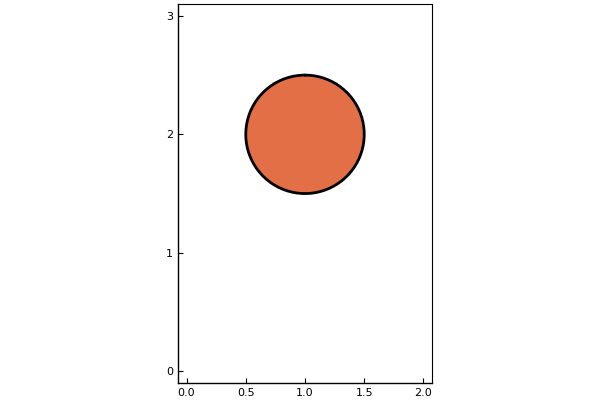

In [194]:
p1 = plot(xg,yg,uhist[1],levels=contour_levels)
for i = 1:sys.nbody
    plot!(p1,vshist[1][i,[1:nverts;1],1], vshist[1][i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
end
p1

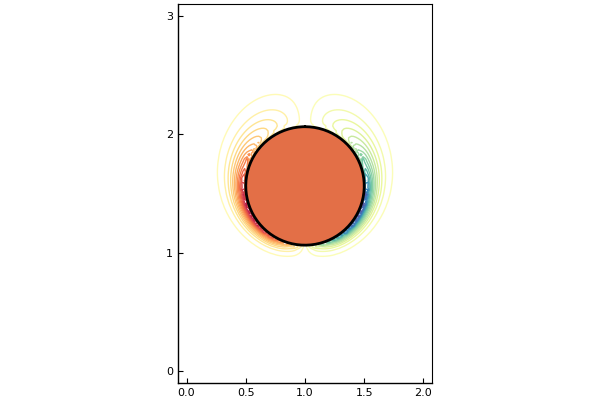

In [195]:
p2 = plot(xg,yg,uhist[end],levels=contour_levels)
for i = 1:sys.nbody
    plot!(p2,vshist[end][i,[1:nverts;1],1], vshist[end][i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
end
p2

#### Body position at t=0 and t=tf

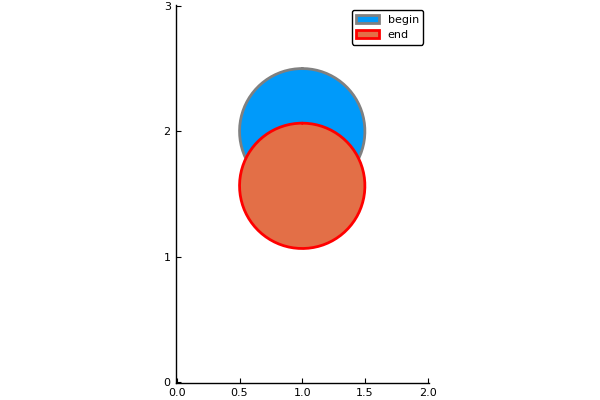

In [196]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,[1:nverts;1],1], vshist[1][i,[1:nverts;1],3],linewidth=2,linecolor="grey",label="begin",fill=true)
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,[1:nverts;1],1], vshist[end][i,[1:nverts;1],3],linewidth=2,linecolor="red",label="end",fill=true)
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1)
pb

#### Make a gif

In [197]:
# anim = @animate for j = 1:length(uhist)
#     plot(xg,yg,uhist[j],levels=contour_levels)
#     for i = 1:sys.nbody
#         plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="grey")
#     end
# end

# gif(anim, "movies/"*gif_name, fps = fps)

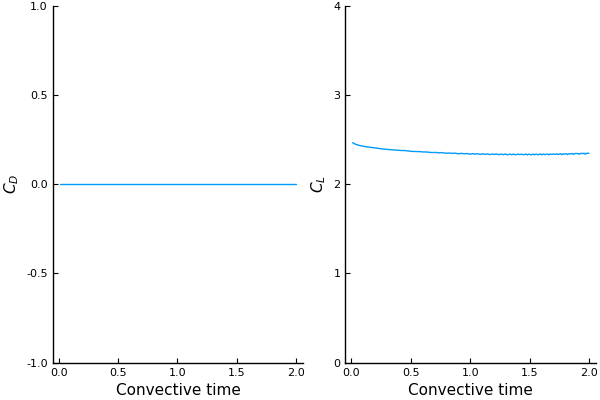

In [215]:
px = plot(thist,2*fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,4),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

In [199]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].bs[1].v[6])
    push!(phist,bdhist[i].bs[1].x_i[3]-bdhist[1].bs[1].x_i[3])    
end

ahist = []
for i in 1:length(vhist)-1
    push!(ahist,(vhist[i+1]-vhist[i])/Δt)
end

In [211]:
ahist

200-element Array{Any,1}:
 -0.24424775130022736
 -0.24239618394810572
 -0.2409832622679636 
 -0.23981773753814165
 -0.2388193845453959 
 -0.23793933429768643
 -0.23714691318835468
 -0.23642137239338057
 -0.23574895521165892
 -0.23511818515476388
 -0.2345190399410911 
 -0.2339483784254883 
 -0.23346375840671665
  ⋮                  
 -0.1925337325674903 
 -0.1925287451961244 
 -0.1911844989333833 
 -0.19254227700484794
 -0.19130994877430973
 -0.19142950942565018
 -0.19078149183133775
 -0.19069314643889168
 -0.19132867190263525
 -0.18982723716651773
 -0.19063104796556152
 -0.18964936202010563

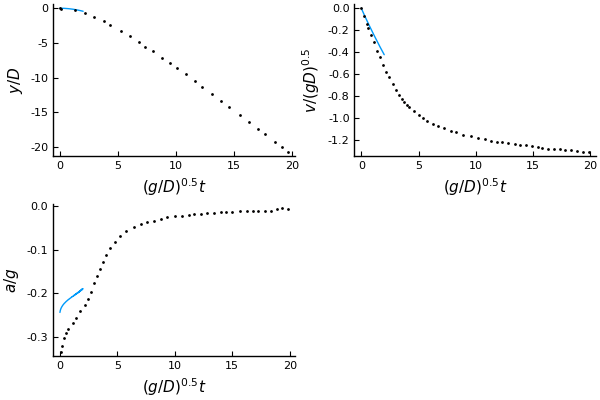

In [201]:
using CSV

pdata = CSV.read("local_run/validation/csv/position.csv",header=false)
xp = [pdata[i,1] for i in 1:length(pdata[1])]
yp = [pdata[i,2] for i in 1:length(pdata[2])]

vdata = CSV.read("local_run/validation/csv/velocity.csv",header=false)
xv = [vdata[i,1] for i in 1:length(vdata[1])]
yv = [vdata[i,2] for i in 1:length(vdata[2])]

adata = CSV.read("local_run/validation/csv/acceleration.csv",header=false)
xa = [adata[i,1] for i in 1:length(adata[1])]
ya = [adata[i,2] for i in 1:length(adata[2])];

pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false)#,ylims=(-25,0))
scatter!(pp,xp,yp,linestyle=:dot,markersize=1)
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false)#,ylims=(-2,0))
scatter!(xv,yv,linestyle=:dot,markersize=1)
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false)#,ylims=(-0.5,0))
scatter!(xa,ya,linestyle=:dot,markersize=1)

plot(pp,pv,pa)

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .jld file

In [202]:
filename = "template_test.jld";

In [207]:
using JLD

save("saved_data/"*filename,
    "bd", bd,
    "xg", xg,
    "yg", yg,
    "uhist", uhist,
    "vshist", vshist,
    "thist", thist,
    "fx", fx,
    "fy", fy,
    "solns", solns
)

HDF5-DIAG: Error detected in HDF5 (1.8.16) thread 140526780046464:
  #000: ../../../src/H5Tfields.c line 87 in H5Tget_nmembers(): not a datatype
    major: Invalid arguments to routine
    minor: Inappropriate type
HDF5-DIAG: Error detected in HDF5 (1.8.16) thread 140526780046464:
  #000: ../../../src/H5Tfields.c line 87 in H5Tget_nmembers(): not a datatype
    major: Invalid arguments to routine
    minor: Inappropriate type


ErrorException: Error getting the number of members

#### Use the following block to extract data when re-open this notebook

In [210]:
# using ViscousFlow, Dyn3d, Plots, JLD

# pyplot()
# clibrary(:colorbrewer)
# default(grid = false)

# d = load("saved_data/template_test.jld")
# thist = d["thist"]
# fx = d["fx"]
# fy = d["fy"]
# xg = d["xg"]
# yg = d["yg"]
# vshist = d["vshist"]
# solns = d["solns"]
# uhist = d["uhist"]
# bd = d["bd"]

# @get bd (bs,js,sys);

KeyError: KeyError: key "thist" not found